## CCS - final project - Jona Kao, Niclas Leinen
##### This jupyter notebook contains code for three different models. Use the following links to quickly get to the code of the different models and other sections of the code!

<b>[Libraries](#libraries)</b> \
<b>[Data Import](#data-import)</b> \
<b>[k and $\beta$](#k-and-beta-values)</b> \
<b>[Model 1: Ex-Gaussian model](#model-1-ex-gaussian-model)</b>

# Libraries
---

In [22]:
import scipy
from scipy.optimize import minimize
from scipy.stats import exponnorm
from scipy.stats import ks_1samp
from scipy.stats import ks_2samp
from scipy.stats import norm
from scipy import stats
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---
# Setting the random seed for reproducabilty
---

In [23]:
np.random.seed(12)

---
# Data import
---

We first define the path to the folder containing the sample data.

In [24]:
# Note: The given filepath is a RELATIVE filepath,
# meaning that the data folder must lie in the same
# directory as the jupyter notebook file!
DATAPATH = "Data/"
mat_files = [f for f in os.listdir(DATAPATH) if f.endswith(".mat")]

Then we create a function that loads and extracts the contents of a .mat-file.

In [25]:
def load_mat_file(file_path):
    mat_data = scipy.io.loadmat(file_path)

    # Extract data and convert to DataFrames
    data_train = pd.DataFrame(mat_data['data_train'])
    data_test = pd.DataFrame(mat_data['data_test'])
    data_labels = [label[0] for label in mat_data['data_labels'][0]]  # Convert to list of column names

    # Assign column names
    data_train.columns = data_labels
    data_test.columns = data_labels

    return data_train, data_test

Now we can load all the data into two dictionaries: <i>TRAIN_DATA</i> and <i>TEST_DATA</i>.

In [26]:
TRAIN_DATA = {}
TEST_DATA = {}

for mat_file in mat_files:
    filepath = os.path.join(DATAPATH, mat_file)
    train, test = load_mat_file(filepath)
    
    # Store using participant ID (file name without .mat)
    participant_id = mat_file.replace(".mat", "")
    TRAIN_DATA[participant_id] = train
    TEST_DATA[participant_id] = test

We need to filter the data with a missing action value.

In [27]:
# Assuming TRAIN_DATA and TEST_DATA are dictionaries with participant IDs as keys
train_data_with_filtered_actions = {}
test_data_with_filtered_actions = {}

for participant_id, data in TRAIN_DATA.items():
    # Filter out rows where the action column has a value of 0
    filtered_data = data[data["action (1=immediate, 2=delayed, 0=missing)"] != 0]
    filtered_data = filtered_data.reset_index(drop=True)
    train_data_with_filtered_actions[participant_id] = filtered_data

for participant_id, data in TEST_DATA.items():
    # Filter out rows where the action column has a value of 0
    filtered_data = data[data["action (1=immediate, 2=delayed, 0=missing)"] != 0]
    filtered_data = filtered_data.reset_index(drop=True)
    test_data_with_filtered_actions[participant_id] = filtered_data

# Replace the original dictionaries with the filtered ones
TRAIN_DATA = train_data_with_filtered_actions
TEST_DATA = test_data_with_filtered_actions

We will then define the labels of the data table for easier future use.

In [28]:
LABEL_IMM_OUT = "immOutcome"
LABEL_DEL_OUT = "delOutcome"
LABEL_DELAY = "delay"
LABEL_CHOICE = "action (1=immediate, 2=delayed, 0=missing)"
LABEL_P_IMM = "p_imm"
LABEL_RT = "RT"

The data is now fully loaded into <i>TRAIN_DATA</i> and <i>TEST_DATA</i> with the following layout: \
<i>data_set</i>[x] = data from participant x.

We will be using these datasets for all of our models.

---
# Figuring out values for $k$ and $\beta$
---

We will need the following formulas in order to calculate our values for $k$ and $\beta$:

(1) $sv_{delayed,i}$ = $\frac{delayed\_outcome}{1+k*delay}$

(2) $p_{delayed,i}$ = $\frac{1}{1+e^{-\beta(sv_{delayed} - sv_{immediate})}}$

(3) $log_L$ = $\sum_{i = 1}^n c_i log(p_{delayed,i}) + (1 - c_i) log(1-p_{delayed,i})$

Therefore, we will need to make some intital estimates for $k$ and $\beta$.
In this case, we chose random values using the random library, and we got the values $k = 0.000237$ and $\beta = 4.423591$

In [29]:
INITIAL_k = 0.000237
INITIAL_beta = 4.423591

We have to define the behaviour of the model when dealing with sample entries that are missing an <i>action</i>-value. (<i>action</i> = 0).
<ul>
    <li>Option 1: Set value to an <b>immediate</b> response.</li>
    <li>Option 2: Set value to a <b>delayed</b> response.</li>
    <li>Option 3: Set value to a <b>random</b> response.</li>
    <li>Option 4: <b>Ignore</b> entries with missing <i>action</i>-value</li>
</ul>

We went ahead with choosing option 1. As not many entries are missing <i>action</i>-value, the impact of this decision remains minimal, which we tested after we had successfully built our first model.

In [30]:
# Helper function to clamp action values between 0 and 1.
# Remaps action values of 2.0 to 1.0 (delayed) and all other values to 0.0 (immediate).
# This also covers the case of missing action values, which are treated as immediate.
def action_values_clamp01(actions):
    clamped_actions = []
    
    for action in actions:
        if action == 2.0:
            clamped_actions.append(1.0)
        else:
            clamped_actions.append(0.0)
    
    return clamped_actions

#### $k$-log-likelihood-function

In [31]:
def log_likelihood_k(k, data_set, participant):
    beta = INITIAL_beta
    log_L = 0

    data_matrix = data_set[participant]
    
    sample_size = len(data_matrix)
    
    sv_immediates = data_matrix[LABEL_IMM_OUT]
    
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_DELAY]
    actions = data_matrix[LABEL_CHOICE]
    
    clamped_actions = action_values_clamp01(actions)
    
    
    for i in range(sample_size):
        sv_delayed = delayed_outcomes[i] / (1.0 + k * max(delays[i], 1e-10))
        
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        log_L += clamped_actions[i] * np.log(p_delayed) + (1.0 - clamped_actions[i]) * np.log(1.0 - p_delayed)

    return -log_L

Minimize $k$ values with this function:

In [32]:
results_k = []

for participant in TRAIN_DATA:
    result = minimize(log_likelihood_k, INITIAL_k, args=(TRAIN_DATA, participant))
    results_k.append(result.x)

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\629314813.py:21: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\629314813.py:21: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\629314813.py:21: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\629314813.py:21: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\629314813.py:21: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\629314813.py:21

#### $\beta$-log-likelihood-function using calculated $k$-values <a id="m1_beta_llf"></a>

In [33]:
def log_likelihood_beta(beta, data_set, participant, participant_id):
    # Retrieve the k value for the current participant
    k = results_k[participant_id]
    log_L = 0

    # Get the data matrix for the current participant
    data_matrix = data_set[participant]
    
    # Determine the sample size
    sample_size = len(data_matrix)
    
    # Extract relevant columns from the data matrix
    sv_immediates = data_matrix[LABEL_IMM_OUT]
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_DELAY]
    actions = data_matrix[LABEL_CHOICE]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)

    # Loop through each sample in the data matrix
    for i in range(sample_size):
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[i] / (1.0 + k * max(delays[i], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood
        log_L += clamped_actions[i] * np.log(p_delayed) + (1.0 - clamped_actions[i]) * np.log(1.0 - p_delayed)


    return -log_L

Minimize $\beta$ with this function:

In [34]:
# Initialize an empty list to store beta results
results_beta = []

i = 0

for participant in TRAIN_DATA:
    # Minimize the log likelihood function to find the best beta value
    result = minimize(log_likelihood_beta, INITIAL_beta, args=(TRAIN_DATA, participant, i))
    results_beta.append(result.x)

    i += 1

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\3635345530.py:27: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\3635345530.py:27: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\3635345530.py:27: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))


We now have $k$ and $\beta$ values that we can universally use for all models.

---
# Accuracy test
---

We define a function that predicts choices given the $k$ and $\beta$ of the participant. \
The model will predict the action to be <i>immediate</i> if $p \leq 0.5$, else <i>delayed</i>.

In [35]:
def predict_choices(k, beta, participant):
    data_matrix = TEST_DATA[participant]

    sv_immediates = data_matrix[LABEL_IMM_OUT]
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_RT]

    sample_size = len(data_matrix)
    
    predicted_choices = []
    
    # Loop through each sample in the data matrix
    for i in range(sample_size):
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[i] / (1.0 + k * max(delays[i], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        if p_delayed > 0.5:
            predicted_choices.append(1)
        else:
            predicted_choices.append(0)
    
    return predicted_choices

We further define a function that calculates the prediction accuries by comparing the predictions to the actual choices made in the test-dataset. The output ranges from 0-100 (percentage).

In [36]:
def predict_accuracies(k, beta, participant):
    predicted_choices = predict_choices(k, beta, participant)
    
    actions = TEST_DATA[participant][LABEL_CHOICE]
    
    sample_size = len(actions)
    
    clamped_actions = action_values_clamp01(actions)

    correct_guesses = 0
    
    for i in range(sample_size):
        if clamped_actions[i] == predicted_choices[i]:
            correct_guesses += 1
    
    return correct_guesses / sample_size * 100

Now we can test the accuracies we would get when using the $k$ and $\beta$ values we calculated above only (meaning no model). 

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\2062185492.py:18: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))


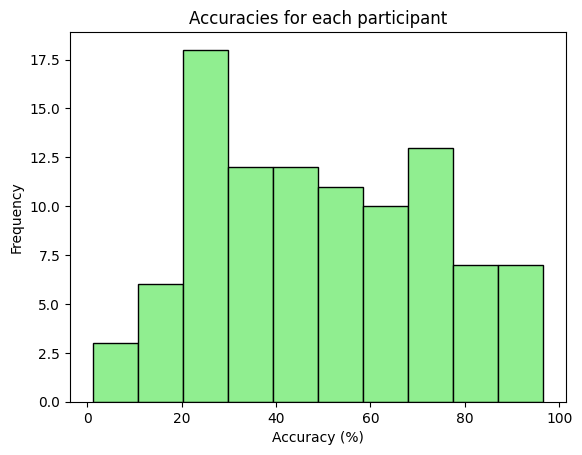

In [37]:
PREDICTION_ACCURACIES_k_beta = []

for i, participant in enumerate(TEST_DATA):
    accuracy_score = predict_accuracies(results_k[i], results_beta[i], participant)
    PREDICTION_ACCURACIES_k_beta.append(accuracy_score)

plt.hist(PREDICTION_ACCURACIES_k_beta, bins=10, color="lightgreen", edgecolor="black")
plt.title("Accuracies for each participant")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()


---
# Distribution of reaction times
---

Another step we will need to do is extract all the reaction times from the dataset.

In [38]:
def get_reaction_times(data_set):
    reaction_times = []
    
    # Get reaction times from each participant in the training data
    for participant in data_set:
        data_matrix = TRAIN_DATA[participant]
        reaction_times.append((data_matrix[LABEL_RT]))
    
    return reaction_times

We can now get started with our first model.

---
# Model 1: Ex-Gaussian Model
---

Fit an Ex-Gaussian distribution to the reaction time data using scipy.exponnorm

In [39]:
TRAIN_RTs = get_reaction_times(TRAIN_DATA)

# Ensure each reaction_time_record is a 1-dimensional array and remove NaN values
# reaction_times_model_1 = [np.array(rt).flatten() for rt in TRAIN_RTs]
# reaction_times = [rt[~np.isnan(rt)] for rt in TRAIN_RTs]

ex_gaussian_fits = []

for rt in TRAIN_RTs:
    #fits.append(exponnorm.fit(reaction_time_record))
    ex_gaussian_fits.append(exponnorm.fit(rt))

n = len(ex_gaussian_fits)

# Extracting the parameters
K_values = [ex_gaussian_fits[i][0] for i in range(n)]
loc_values = [ex_gaussian_fits[i][1] for i in range(n)]
scale_values = [ex_gaussian_fits[i][2] for i in range(n)]

tau_values = [K_values[i] * scale_values[i] for i in range(n)]
mu_values = loc_values
sigma_values = scale_values

## Testing the null hypothesis

In [40]:
# Initialize lists to store fitted CDFs, KS statistics, and p-values
fitted_cdfs = []
ks_statistics = []
p_values = []

# Loop through each set of K, mu, and sigma values
for i in range(len(K_values)):
    # Create a lambda function for the fitted CDF using the exponentially modified normal distribution
    fitted_cdfs.append(lambda x: exponnorm.cdf(x, K_values[i], loc=mu_values[i], scale=sigma_values[i]))
    
    # Perform the Kolmogorov-Smirnov test for goodness of fit
    ks_statistic, p_value = ks_1samp(TRAIN_RTs[i], fitted_cdfs[i])
    
    # Append the KS statistic and p-value to their respective lists
    ks_statistics.append(ks_statistic)
    p_values.append(p_value)


i = 0

for p_value in p_values:
    # Check if the p-value is less than 0.05 (significance level)
    if p_value < 0.05:
        print(f"Reject null hypothesis for participant with id {i}: {p_value:.4f}")

    i += 1

# [DEBUG] Print the mean of all p-values
# print(f"Mean of all p_values: {np.mean(p_values):.4f}")

Reject null hypothesis for participant with id 56: 0.0473


The null hyptothesis test demonstrates that the model holds true for all participants except for participant <b>#57</b>. \
The mean <i>p_value</i> lies at 0.7738. \
For every single other participant, the <i>p_value</i> is much greater than 0.05, meaning that there is an extremely small to no difference between our data and the ex-gaussian distribution. Therefore, we are going to use this approach to build our bimodal model.

## Creating a unified log-likelihood function

We first need to define the Ex-Gaussian-likelihood function:

In [41]:
def ex_gaussian_likelihood(participant_reaction_times, K_value, mu_value, sigma_value):
    return exponnorm.logpdf(participant_reaction_times, K_value, loc=mu_value, scale=sigma_value)

The joint-log-likelihood can be calculated by the expression  $$log_{L,i}(joint)=log_{L,i}(p_{delay, i}) + log_{L,i}(reactiontime_i)$$

In [42]:
def joint_log_likelihood_train(params, data_set, participant, i):
    log_L = 0
    mu, sigma, K, beta, k = params
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    log_L_rt = 0
    
    data_matrix = data_set[participant]
    
    sample_size = len(data_matrix)
    
    sv_immediates = data_matrix[LABEL_IMM_OUT]
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_DELAY]
    actions = data_matrix[LABEL_CHOICE]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)
    
    for j in range(sample_size):
        reaction_time_likelihood = ex_gaussian_likelihood(TRAIN_RTs[i][j], K, mu, sigma)

        log_L_rt += reaction_time_likelihood
        
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[j] / (1.0 + k * max(delays[j], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += clamped_actions[j] * np.log(p_delayed) + (1.0 - clamped_actions[j]) * np.log(1.0 - p_delayed)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L += log_L_rt
    
    return -log_L

With this function we can now optimize $\mu$, $\sigma$, $K$, $\beta$ and $k$.

In [43]:
# Initialize index and results list
results_model_1 = []

# Loop through each participant in the training data
for i, participant in enumerate(TRAIN_DATA):
    
    # Extract the initial parameters for the current participant
    # initial params seemed buggy, potential fix:
    initial_params = [
        np.ravel(mu_values[i])[0],
        np.ravel(sigma_values[i])[0],
        np.ravel(K_values[i])[0],
        np.ravel(results_beta[i])[0],
        np.ravel(results_k[i])[0]
    ]
    
    bounds = [
        (None, None),
        (None, None),
        (None, None),
        (0.1, 10),
        (1e-6, 1)
    ]
    
    # Convert the initial parameters to np.array
    initial_params = np.array(initial_params)
    
    # Minimizing
    result = minimize(joint_log_likelihood_train, initial_params, args=(TRAIN_DATA, participant, i), bounds=bounds)
    results_model_1.append(result.x)

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\2571579530.py:30: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))


Now let's look at the results:

In [44]:
for result in results_model_1:
    print(f"mu_value = {result[0]}")
    print(f"sigma_value = {result[1]}")
    print(f"K_value = {result[2]}")
    print(f"beta_result = {result[3]}")
    print(f"k_result = {result[4]}")
    print("--------------------------------")

mu_value = 1124.411519670277
sigma_value = 123.0040977634712
K_value = 8.077244568725757
beta_result = 0.2788544204952753
k_result = 0.014790936032792561
--------------------------------
mu_value = 1076.9662762228643
sigma_value = 186.47762778369798
K_value = 4.075080232909666
beta_result = 10.0
k_result = 0.028124611539429047
--------------------------------
mu_value = 1994.4924037750434
sigma_value = 154.45720612460767
K_value = 5.219455817733677
beta_result = 4.466463371468437
k_result = 0.0013485850664986766
--------------------------------
mu_value = 978.1262109088717
sigma_value = 205.2174706154246
K_value = 1.5685861463717583
beta_result = 6.025890914314569
k_result = 0.00976619134590919
--------------------------------
mu_value = 1460.0617128818483
sigma_value = 243.2063335014367
K_value = 2.01340660749924
beta_result = 1.605971299497198
k_result = 0.008564363763044244
--------------------------------
mu_value = 1749.990024620202
sigma_value = 354.64144971508847
K_value = 1.216

---

# Testing Model 1

---

In [45]:
def joint_log_likelihood_test(participant, i):
    log_L = 0
    beta = results_model_1[i][3]
    k = results_model_1[i][4]
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    log_L_rt = 0
    
    # Get the data matrix for the current participant
    data_matrix = TEST_DATA[participant]
    # Determine the sample size
    sample_size = len(data_matrix)
    # Extract relevant columns from the data matrix
    
    sv_immediates = data_matrix[LABEL_IMM_OUT]
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_DELAY]
    actions = data_matrix[LABEL_CHOICE]
    reaction_times = data_matrix[LABEL_RT]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)
    
    # Loop through each sample in the data matrix
    for j in range(sample_size):
        reaction_time_likelihood = ex_gaussian_likelihood(reaction_times[j], results_model_1[i][2], results_model_1[i][0], results_model_1[i][1])
        log_L_rt += reaction_time_likelihood
        
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[j] / (1.0 + k * max(delays[j], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += clamped_actions[j] * np.log(p_delayed) + (1.0 - clamped_actions[j]) * np.log(1.0 - p_delayed)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L += log_L_rt
    
    return -log_L

In [46]:
test_results_model_1 = []

# Loop through each participant in the training data
for i, participant in enumerate(TEST_DATA):
    # Calculate the joint log likelihood with the trained values
    result = joint_log_likelihood_test(participant, i)
    
    # Append the result to the results list
    test_results_model_1.append(result)

### AIC & BIC test

In [47]:
def compute_aic_bic_model(log_likelihood, num_params, num_trials):
    AIC = 2 * num_params - 2 * log_likelihood
    BIC = num_params * np.log(num_trials) - 2 * log_likelihood
    
    return AIC, BIC


for i, participant in enumerate(TRAIN_DATA):
    params = results_model_1[i]
    
    joint_log_likelihood_model_1 = joint_log_likelihood_train(params, TRAIN_DATA, participant, i)
    num_trials = len(TRAIN_DATA[participant])
    
    aic, bic = compute_aic_bic_model(-joint_log_likelihood_model_1, 5, num_trials)

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\2571579530.py:30: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))


### KS test

In [48]:
TEST_RTs = get_reaction_times(TEST_DATA)

for i, participant in enumerate(TEST_DATA):
    predicted_reaction_times = exponnorm.rvs(results_model_1[i][2], results_model_1[i][0], results_model_1[i][1], size=len(TEST_DATA[participant]))
    
    ks_stat, p_value = ks_2samp(predicted_reaction_times, TEST_RTs[i])
    
    print(f"KS Stat: {ks_stat}, p-value: {p_value}")
    
    #stats.probplot(predicted_reaction_times, dist=exponnorm, sparams=(results_model_1[i][2], results_model_1[i][0], results_model_1[i][1]), plot=plt)
    #plt.title("Q-Q Plot: Observed RTs vs. Predicted RTs (Ex-Gaussian)")
    #plt.show()

KS Stat: 0.06751054852320675, p-value: 0.9454945315075189
KS Stat: 0.06805555555555555, p-value: 0.9436414658007334
KS Stat: 0.09305555555555556, p-value: 0.6879604528138933
KS Stat: 0.11215083798882682, p-value: 0.44940156688194827
KS Stat: 0.07916666666666666, p-value: 0.8503230823201612
KS Stat: 0.1388888888888889, p-value: 0.2148544228367713
KS Stat: 0.07083333333333333, p-value: 0.9247490409238771
KS Stat: 0.10138888888888889, p-value: 0.5835158683358517
KS Stat: 0.08376068376068375, p-value: 0.8032007830139052
KS Stat: 0.0944364161849711, p-value: 0.6698813597159268
KS Stat: 0.07222222222222222, p-value: 0.9140406920247063
KS Stat: 0.07777777777777778, p-value: 0.8643624829793103
KS Stat: 0.05768156424581006, p-value: 0.9860132763591691
KS Stat: 0.10833333333333334, p-value: 0.4995562403691083
KS Stat: 0.0931082981715893, p-value: 0.6841415847067882
KS Stat: 0.0875, p-value: 0.7564271324903237
KS Stat: 0.1098314606741573, p-value: 0.47669037501843503
KS Stat: 0.12916666666666668,

### Accuracy test

To test overall accuracy, we will define a function that simulates always picking <i>the same option</i>.

In [49]:
def fixed_choice_accuracy(participant, option):
    correct_guesses = 0
    
    actions = TEST_DATA[participant][LABEL_CHOICE]
    
    clamped_actions = action_values_clamp01(actions)
    
    for i in range(len(clamped_actions)):
        if clamped_actions[i] == option:
            correct_guesses += 1
    
    return correct_guesses / len(clamped_actions) * 100

We will compute these fixed-choice accuracies <b>once</b> and reuse them for each model.

50.05907818891277


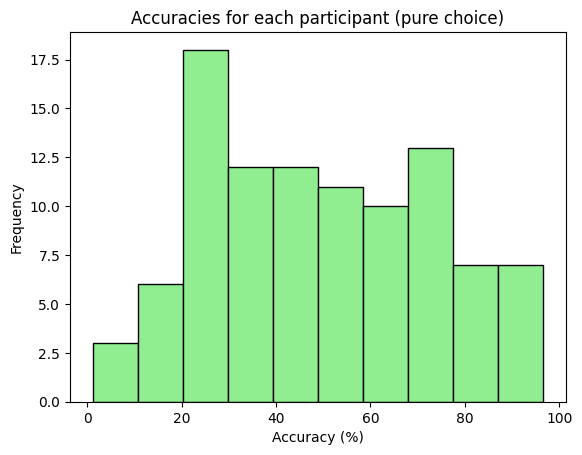

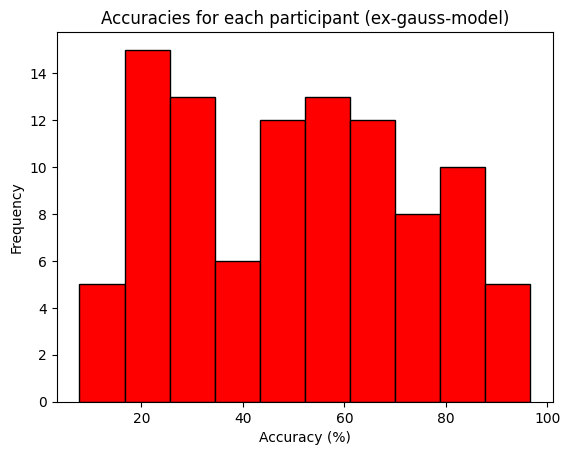

In [50]:
prediction_accuracies_model_1 = []

ACCURACY_SCORES_FIXED_CHOICE_IMMEDIATE = []
ACCURACY_SCORES_FIXED_CHOICE_DELAYED = []


for i, participant in enumerate(TEST_DATA):
    accuracy_score = predict_accuracies(results_model_1[i][4], results_model_1[i][3], participant)
    prediction_accuracies_model_1.append(accuracy_score)

    # These are the values that are only computed once.
    # They don't change per model.
    accuracy_score_always_immediate = fixed_choice_accuracy(participant, 0)
    accuracy_score_always_delayed = 100 - accuracy_score_always_immediate
    
    ACCURACY_SCORES_FIXED_CHOICE_IMMEDIATE.append(accuracy_score_always_immediate)
    ACCURACY_SCORES_FIXED_CHOICE_DELAYED.append(accuracy_score_always_delayed)

#print(min(PREDICTION_ACCURACIES_k_beta) - min(prediction_accuracies_model_1))
#print(np.mean(PREDICTION_ACCURACIES_k_beta) - np.mean(prediction_accuracies_model_1))
#print(max(PREDICTION_ACCURACIES_k_beta) - max(prediction_accuracies_model_1))

print(np.mean(prediction_accuracies_model_1))

plt.hist(PREDICTION_ACCURACIES_k_beta, bins=10, color="lightgreen", edgecolor="black")
plt.title("Accuracies for each participant (pure choice)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

plt.hist(prediction_accuracies_model_1, bins=10, color="red", edgecolor="black")
plt.title("Accuracies for each participant (ex-gauss-model)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

---

# Model 2: LBA Model 

---

In [51]:
# LBA PDF
def lba_pdf(rt, v, b, A, t0, choice):
    rt_adj = rt - t0
    
    if rt_adj <= 0:
        return 1e-8
    
    choice = int(choice)
    v_win = v[choice]
    v_lose = v[1 - choice]
    
    if v_win <= 0 or v_lose <= 0:
        return 1e-8
    
    t = rt_adj
    density = (v_win / t) * (1 - np.exp(-v_win * (b - A) / t)) * np.exp(-v_lose * (b - A) / t)
    
    return max(density, 1e-8) if np.isfinite(density) else 1e-8

In [52]:
# LBA Log-Likelihood (no debug prints)
def lba_log_likelihood(params, data_set, participant):
    v_imm, v_del, b, A, t0 = params
    v = [v_imm, v_del]
    
    log_lik = 0
    
    data_matrix = data_set[participant]
    
    actions = data_matrix[LABEL_CHOICE]
    
    clamped_actions = action_values_clamp01(actions)
    
    sample_size = len(data_matrix)
    
    for j in range(sample_size):
        rt = data_matrix["RT"][j] / 1000
        choice = clamped_actions[j]
        
        density = lba_pdf(rt, v, b, A, t0, choice)
        log_lik += np.log(density)
    
    return -log_lik

In [53]:
def joint_log_likelihood_lba(params, data_set, participant):
    log_L = 0
    v1, v2, b, A, t0, k, beta = params
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    
    data_matrix = data_set[participant]
    
    sample_size = len(data_matrix)
    
    sv_immediates = data_matrix["immOutcome"]
    delayed_outcomes = data_matrix["delOutcome"]
    delays = data_matrix["delay"]
    actions = data_matrix["action (1=immediate, 2=delayed, 0=missing)"]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)
    
    for j in range(sample_size):
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[j] / (1.0 + k * max(delays[j], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += clamped_actions[j] * np.log(p_delayed) + (1.0 - clamped_actions[j]) * np.log(1.0 - p_delayed)
    
    log_L_lba = lba_log_likelihood([v1, v2, b, A, t0], data_set, participant)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L += log_L_lba
    
    return -log_L
    

In [66]:
BOUNDS_MODEL_2 = [
    (0.1, 1),  # v1 [0]
    (0.1, 1),  # v2 [1]
    (0.1, 5),  # A [2]
    (0.1, 5),  # b [3]
    (0, 0.5),  # t0 [4]
    (1e-6, 1),  # k [5]
    (0.1, 10)   # beta [6]
]

INITIAL_PARAMS_MODEL_2 = [ 0.5, 0.5, 5, 1.5, 0.3, INITIAL_k, INITIAL_beta ]

In [ ]:
results_model_2 = []

from scipy.optimize import differential_evolution

for i, participant in enumerate(TRAIN_DATA):
    #result = minimize(joint_log_likelihood_lba, initial_params, args=(TRAIN_DATA, participant))
    result = differential_evolution(joint_log_likelihood_lba, BOUNDS_MODEL_2, args=(TRAIN_DATA, participant))
    results_model_2.append(result.x)

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\3801037551.py:25: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\3632927686.py:16: RuntimeWarning: overflow encountered in scalar multiply
  density = (v_win / t) * (1 - np.exp(-v_win * (b - A) / t)) * np.exp(-v_lose * (b - A) / t)
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\3632927686.py:16: RuntimeWarning: overflow encountered in exp
  density = (v_win / t) * (1 - np.exp(-v_win * (b - A) / t)) * np.exp(-v_lose * (b - A) / t)


In [57]:
for result in results_model_2:
    print(result)

[0.75176224 0.59014803 2.90048994 3.68268369 0.10238811 0.01479087
 0.27885198]
[ 0.22275759  0.49853155  3.05199205  4.68570105  0.09193887  0.01032269
 10.        ]
[8.03832852e-01 3.76026222e-01 2.76953558e+00 4.84670401e+00
 1.54531303e-01 1.31329910e-03 4.86497126e+00]
[0.23096661 0.52893823 0.24147113 3.89228894 0.45289189 0.00979261
 6.8042261 ]
[0.47904922 0.51214731 2.91388581 4.78070834 0.00584942 0.0085721
 1.61669171]
[0.35279047 0.35341384 1.81788679 2.09236397 0.38847183 0.52543413
 6.88560315]
[0.48278071 0.36908206 0.62617121 0.81457957 0.06918013 0.00948043
 9.31577545]
[5.04256604e-01 7.88112445e-01 3.39755280e+00 3.86758994e+00
 3.89810243e-01 8.30880373e-05 5.34363301e+00]
[2.04109774e-01 6.00322161e-01 3.46990796e-01 2.53405879e+00
 2.47525315e-01 1.06059422e-03 1.16197338e+00]
[0.49287909 0.60723942 1.19732442 2.19308129 0.49030139 0.23007977
 0.1       ]
[6.57574815e-01 8.15108832e-01 3.03873641e+00 4.47852032e+00
 3.15695400e-01 9.29255985e-03 9.41090331e+00]
[5

### AIC & BIC test

### Accuracy test

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\2062185492.py:18: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))


7.777777777777778
50.294848950841974
96.66666666666667


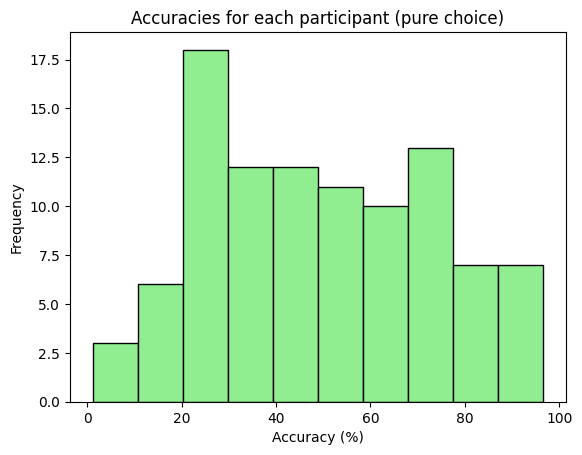

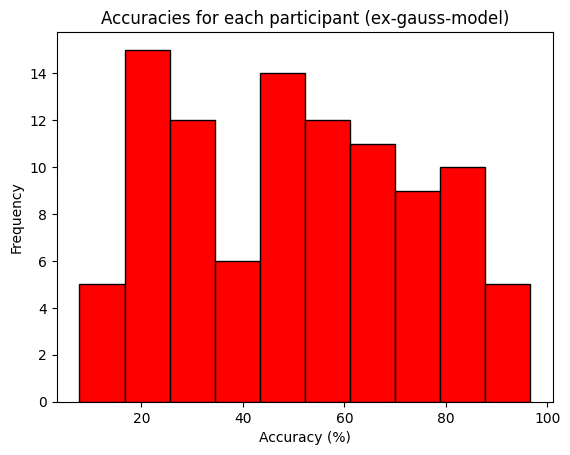

In [ ]:
prediction_accuracies_model_2 = []

for i, participant in enumerate(TEST_DATA):
    accuracy_score = predict_accuracies(results_model_2[i][5], results_model_2[i][6], participant)
    prediction_accuracies_model_2.append(accuracy_score)

print(min(prediction_accuracies_model_2))
print(np.mean(prediction_accuracies_model_2))
print(max(prediction_accuracies_model_2))

plt.hist(PREDICTION_ACCURACIES_k_beta, bins=10, range=(0, 100), color="lightgreen", edgecolor="black")
plt.title("Accuracies for each participant (pure choice)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

plt.hist(prediction_accuracies_model_2, bins=10, range=(0, 100), color="red", edgecolor="black")
plt.title("Accuracies for each participant (ex-gauss-model)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

---

# Testing Model 2

---

In [59]:
#for i, participant in enumerate(TEST_DATA):
#    starting_points = np.random.uniform(0, results_model_2[i][2], 1000)
#    
#    decision_times = (results_model_2[i][3] - starting_points) / min(results_model_2[i][0], results_model_2[i][1])
#    
#    predicted_reaction_times_lba = decision_times + results_model_2[i][4]
#    
#    #print(predicted_reaction_times_lba)
#    
#    #print("\n\n\n")
#    
#    reaction_times = TEST_DATA[participant]["RT"]
#    
#    ks_stat, p_value = ks_2samp(predicted_reaction_times_lba, reaction_times)
#    
#    print(f"KS Stat: {ks_stat}, p-value: {p_value}")

---

# Model 3: Name?

---

We first define the joint log likelihood function for our model. We will be using one of the formulas presented in the lectures:

$$ log_L = \sum_{i = 0}^N \log_{L,i,p_{delay}} + \log_{L,i,modelname} $$

where

$$ \log_{L,i,modelname} = \sum_{j = 0}^N -\log(RT_j) - \frac{1}{2}\log(2\pi\sigma) - \frac{(\log(RT_j) - \mu)^2}{2\sigma^2}

In [ ]:
def joint_log_likelihood_model_3(params, data_set, participant):
    log_L = 0
    k, beta, mu, sigma = params
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    
    # Get the data matrix for the current participant
    data_matrix = data_set[participant]
    # Determine the sample size
    sample_size = len(data_matrix)
    # Extract relevant columns from the data matrix
    
    sv_immediates = data_matrix[LABEL_IMM_OUT]
    delayed_outcomes = data_matrix[LABEL_DEL_OUT]
    delays = data_matrix[LABEL_DELAY]
    actions = data_matrix[LABEL_CHOICE]
    reaction_times = data_matrix[LABEL_RT]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)
    
    log_L_model_3 = 0
    
    # Loop through each sample in the data matrix
    for j in range(sample_size):
        log_L_model_3 += - np.log(reaction_times[j]) - 0.5 * np.log(2 * np.pi * sigma) - ((np.log(reaction_times[j]) - mu)**2) / (2 * (sigma**2))
        
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[j] / (1.0 + k * max(delays[j], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += clamped_actions[j] * np.log(p_delayed) + (1.0 - clamped_actions[j]) * np.log(1.0 - p_delayed)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L += log_L_model_3
    
    #print(log_L_model_3, Log_L_p_delay)
    
    return -log_L

In [ ]:
results_model_3 = []

log_mean = 0

for i, participant in enumerate(TRAIN_DATA):
    initial_params = [INITIAL_k, INITIAL_beta, 7, 0.5] # 0.01, beta, 7, 0.5
    
    bounds = [
        (1e-6, 1), # bounds for k
        (0.1, 10), # bounds for beta
        (1, None), # bounds for mu
        (1e-6, None) # bounds for sigma
    ]
    
    result = minimize(joint_log_likelihood_model_3, initial_params, args=(TRAIN_DATA, participant), bounds=bounds, method="L-BFGS-B")
    results_model_3.append(result.x)

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10376\1212992281.py:33: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))


### KS test and MSE test

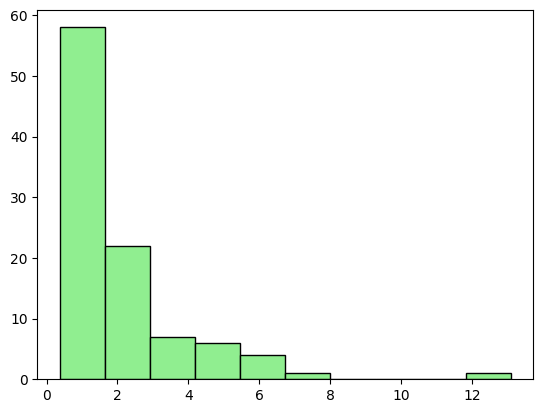

In [ ]:
mse_values_test_model_3 = []

for i, participant in enumerate(TEST_DATA):
    mu = results_model_3[i][2]
    sigma = results_model_3[i][3]
    
    sample_size = len(TEST_RTs[i])
    
    predicted_reaction_time = np.random.lognormal(mean=mu, sigma=sigma, size=sample_size)
    
    ks_stat, p_value = ks_2samp(predicted_reaction_time, TEST_RTs[i])
    
    #stats.probplot(reaction_times_test_model_3[i], dist="lognorm", sparams=(sigma, 0, np.exp(mu)), plot=plt)
    #plt.title("Q-Q Plot: Observed RTs vs. Predicted RTs (Model 5)")
    #plt.show()

    mse = 0
    
    for j in range(sample_size):
        error_seconds = ((TEST_DATA[participant]["RT"][j] - predicted_reaction_time[j])/1000)**2
        
        mse += error_seconds
        
    mse /= sample_size
    
    mse_values_test_model_3.append(mse)
    
    #print(f"KS Stat: {ks_stat}, p-value: {p_value}")
    #print(f"MSE ({i}): {mse}")

plt.hist(mse_values_test_model_3, bins=10, color="lightgreen", edgecolor="black")
plt.show()

### Accuracy test

We can now test the accuracy of our model by calculating predictions and comparing accuracies with the ones we would get if we were to always choose a fixed option.

Our model precision: 50.58%
Always choosing "immediate": 40.06%
Always choosing "delayed": 59.94%


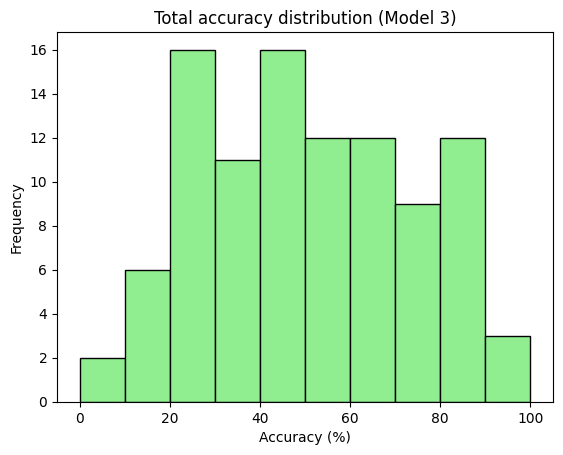

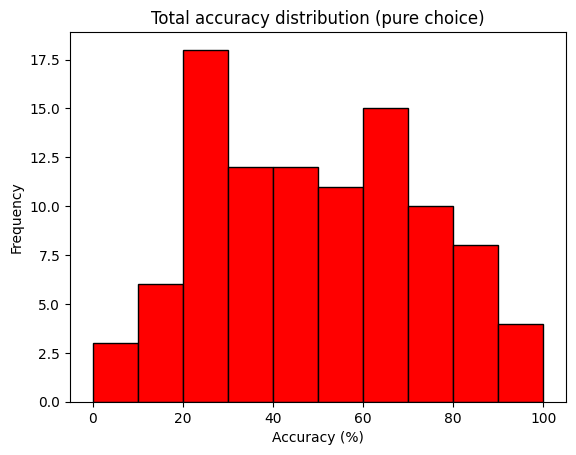

In [ ]:
prediction_accuracies_model_3 = []

for i, participant in enumerate(TEST_DATA):
    accuracy_score = predict_accuracies(results_model_3[i][0], results_model_3[i][1], participant)
    
    accuracy_score_always_immediate = fixed_choice_accuracy(participant, 0)
    accuracy_score_always_delayed = 100 - accuracy_score_always_immediate
    
    prediction_accuracies_model_3.append(accuracy_score)

print(f"Our model precision: {np.mean(prediction_accuracies_model_3):.2f}%")
print(f"Always choosing \"immediate\": {np.mean(ACCURACY_SCORES_FIXED_CHOICE_IMMEDIATE):.2f}%")
print(f"Always choosing \"delayed\": {np.mean(ACCURACY_SCORES_FIXED_CHOICE_DELAYED):.2f}%")

plt.hist(prediction_accuracies_model_3, bins=10, range=(0, 100), color="lightgreen", edgecolor="black")
plt.title("Total accuracy distribution (Model 3)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

plt.hist(PREDICTION_ACCURACIES_k_beta, bins=10, range=(0, 100), color="red", edgecolor="black")
plt.title("Total accuracy distribution (pure choice)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()